<a href="https://colab.research.google.com/github/MManuelG/epc_gold-etf_stat_arb/blob/main/gold_stat_arb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this will be a simple gold vs gold mining etf stat arb, as one can find in "quantitative trading" by Ernest P. Chan. This is example 3.6 in the "backtesting" bookchapter, page 63 in the 2nd edition
# this is an educational example, obviously I overfit it using both train and test metrics + this strategy is old and well known! so even if I had not overfit it, the performance would've still been comparable in a longer run

# please consider buying epchans book, credits to him for this code, a lot of it is his work here!

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# gold and gold mining etfs
tickers = ["GLD", "GDX"]

# I am going to use 5 years of training + 3.5 years (incl. 2025 until today) as test data - following e. p. chans recommendation (p. 61 - "sample size") of using at least ~3 years worth of data for backtest
start_date = "2017-01-01" # [2017, 2021] as training
end_date = "2025-06-29" # yesterday

data = yf.download(tickers, start=start_date, end=end_date)['Close']

print(data.head())
print(data.tail())

/tmp/ipython-input-1-4085895465.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed

Ticker            GDX         GLD
Date                             
2017-01-03  19.933676  110.470001
2017-01-04  20.080244  110.860001
2017-01-05  21.252817  112.580002
2017-01-06  20.510796  111.750000
2017-01-09  20.574923  112.669998
Ticker            GDX         GLD
Date                             
2025-06-23  53.110001  311.079987
2025-06-24  51.860001  306.190002
2025-06-25  51.919998  307.119995
2025-06-26  52.619999  306.779999
2025-06-27  50.730000  301.220001


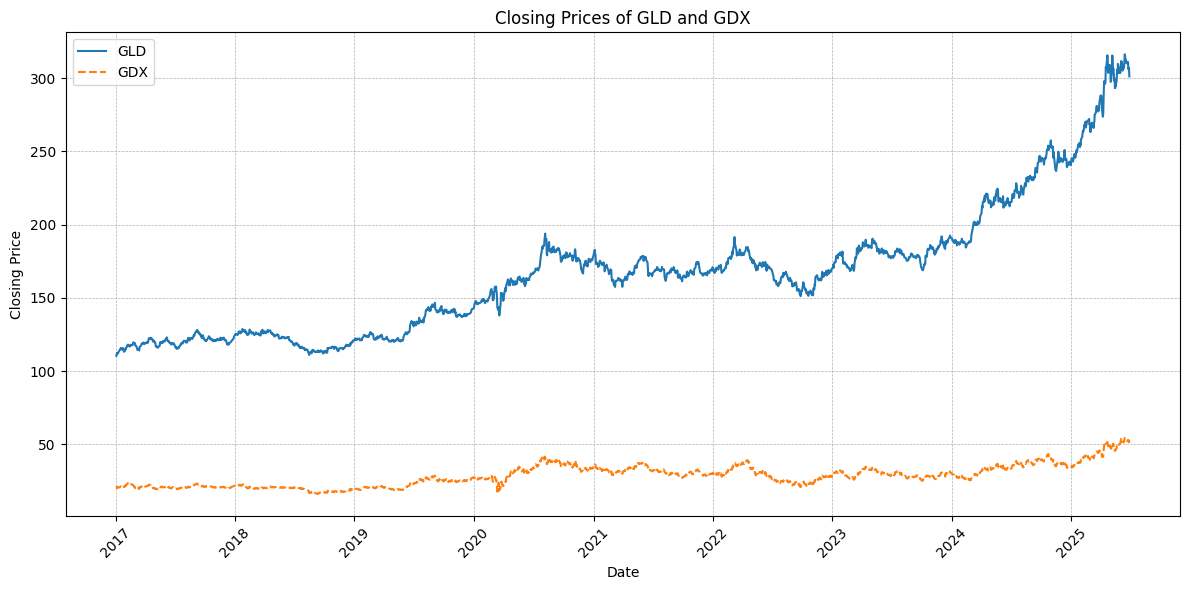

In [2]:
# plot the data so one may look at it
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['GLD'], label='GLD', linestyle='-')
plt.plot(data.index, data['GDX'], label='GDX', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing Prices of GLD and GDX")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
train_start = start_date # [2018, 2022] as training
train_end = "2021-12-31" # so 5 years as training, 3.5 test

train_data = data[(data.index >= train_start) & (data.index <= train_end)]
test_data = data[data.index > train_end] # and everything else as test

'''
print("Training Data (2021-2024):")
print(train_data.head())
print(train_data.tail())

print("\nTesting Data (After 2024):")
print(test_data.head())
print(test_data.tail())
'''

'\nprint("Training Data (2021-2024):")\nprint(train_data.head())\nprint(train_data.tail())\n\nprint("\nTesting Data (After 2024):")\nprint(test_data.head())\nprint(test_data.tail())\n'

Hedge Ratio (GLD/GDX): 5.419845260331872


/tmp/ipython-input-4-3185592271.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['spread'] = train_data['GLD'] - hedge_ratio * train_data['GDX']


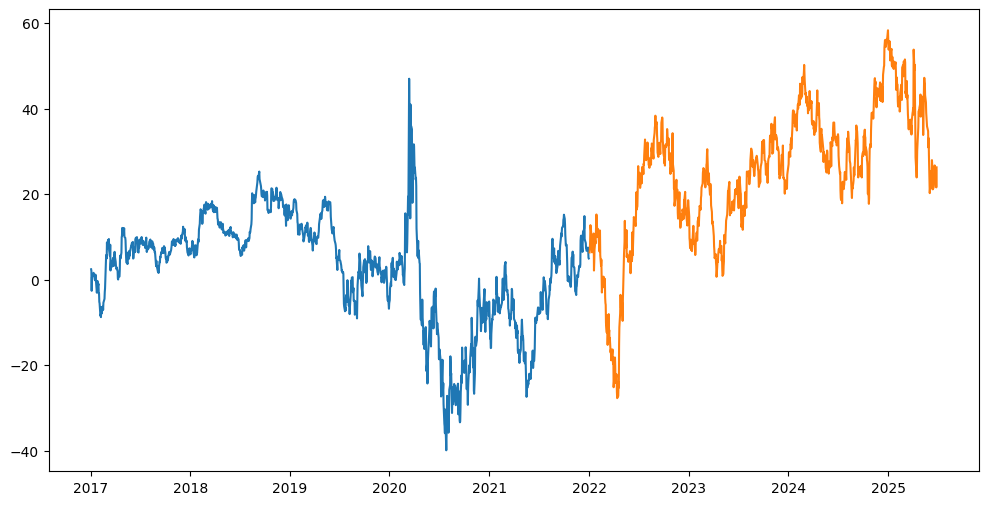

/tmp/ipython-input-4-3185592271.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['spread'] = test_data['GLD'] - hedge_ratio * test_data['GDX']


In [4]:
# compute hedge-ratio, WITHOUT a constant!

# define regular old OLS: GLD = b*GDX + epsilon, GLD and GDX are the respective closing prices
model = sm.OLS(train_data['GLD'], train_data['GDX'])
results = model.fit()

# look at the results
hedge_ratio = results.params['GDX']
print(f"Hedge Ratio (GLD/GDX): {hedge_ratio}")

spread_train = train_data['GLD'] - hedge_ratio * train_data['GDX']
plt.figure(figsize=(12, 6))
plt.plot(spread_train)
train_data['spread'] = train_data['GLD'] - hedge_ratio * train_data['GDX']

# also do the same on the test data, using the model from the training
spread_test = test_data['GLD'] - hedge_ratio * test_data['GDX']
plt.plot(spread_test)
plt.show()
test_data['spread'] = test_data['GLD'] - hedge_ratio * test_data['GDX']


In [5]:
'''
ALTERNATIVELY
'''

# compute hedge-ratio, INCLUDING a constant! (unlike in the book)
# however, the logic here should be without a constant, just for testing!

# remove the following and last line to uncomment
'''
# define regular old OLS: GLD = a + b*GDX + epsilon, GLD and GDX are the respective closing prices
model = sm.OLS(train_data['GLD'], sm.add_constant(train_data['GDX']))
results = model.fit()

# look at the results
hedge_ratio = results.params['GDX']
intercept = results.params['const']
print(f"Hedge Ratio (GLD/GDX): {hedge_ratio}, \nIntercept (GLD/GDX): {intercept}")
# 4.248262616086557, 52.41365815928348

# get spread, logic: this is the result of our regression, i.e. how GLD and GDX are related to each other

spread_train = train_data['GLD'] - intercept - hedge_ratio * train_data['GDX']
plt.figure(figsize=(12, 6))
plt.plot(spread_train)

# also do the same on the test data, using the model from the training
spread_test = test_data['GLD'] - intercept - hedge_ratio * test_data['GDX']
plt.plot(spread_test)
plt.show()
test_data['spread'] = test_data['GLD'] - intercept - hedge_ratio * test_data['GDX']
'''

'\n# define regular old OLS: GLD = a + b*GDX + epsilon, GLD and GDX are the respective closing prices\nmodel = sm.OLS(train_data[\'GLD\'], sm.add_constant(train_data[\'GDX\']))\nresults = model.fit()\n\n# look at the results\nhedge_ratio = results.params[\'GDX\']\nintercept = results.params[\'const\']\nprint(f"Hedge Ratio (GLD/GDX): {hedge_ratio}, \nIntercept (GLD/GDX): {intercept}")\n# 4.248262616086557, 52.41365815928348\n\n# get spread, logic: this is the result of our regression, i.e. how GLD and GDX are related to each other\n\nspread_train = train_data[\'GLD\'] - intercept - hedge_ratio * train_data[\'GDX\']\nplt.figure(figsize=(12, 6))\nplt.plot(spread_train)\n\n# also do the same on the test data, using the model from the training\nspread_test = test_data[\'GLD\'] - intercept - hedge_ratio * test_data[\'GDX\']\nplt.plot(spread_test)\nplt.show()\ntest_data[\'spread\'] = test_data[\'GLD\'] - intercept - hedge_ratio * test_data[\'GDX\']\n'

In [6]:
mean_spread_train = np.mean(spread_train)
std_spread_train = np.std(spread_train)

mean_spread_test = np.mean(spread_test)
std_spread_test = np.std(spread_test)
'''
print(f"Mean Spread (Training): {mean_spread_train}")
print(f"Standard Deviation of Spread (Training): {std_spread_train}")
'''
print(f"Mean Spread (Test): {mean_spread_test}")
print(f"Standard Deviation of Spread (Test): {std_spread_test}")


Mean Spread (Test): 24.960087657329222
Standard Deviation of Spread (Test): 15.484919583441034


In [7]:
# get the z-score (i.e. how many standard deviations is the spread)
test_data['zscore'] = (test_data['spread'] - mean_spread_test) / std_spread_test

# create positions columns
test_data['positions_GLD_long'] = 0
test_data['positions_GDX_long'] = 0
test_data['positions_GLD_short'] = 0
test_data['positions_GDX_short'] = 0

# get the z-score (i.e. how many standard deviations is the spread)
train_data['zscore'] = (train_data['spread'] - mean_spread_train) / std_spread_train

# create positions columns
train_data['positions_GLD_long'] = 0
train_data['positions_GDX_long'] = 0
train_data['positions_GLD_short'] = 0
train_data['positions_GDX_short'] = 0

/tmp/ipython-input-7-1018122630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['zscore'] = (test_data['spread'] - mean_spread_test) / std_spread_test
/tmp/ipython-input-7-1018122630.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['positions_GLD_long'] = 0
/tmp/ipython-input-7-1018122630.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [8]:
# Logic: if the spread is large (i.e. positively two or more stddev.), this means that historically GLD is above GDX
# => GLD should go down, GDX up! => set the positions accordingly! (GLD Short, GDX long)
train_data.loc[train_data['zscore'] >= 2, 'positions_GLD_short'] = -1 # short here means -1
train_data.loc[train_data['zscore'] >= 2, 'positions_GDX_short'] = 1 # long here means +1


# here GDX is above GLD
# => long GLD, short GDX
train_data.loc[train_data['zscore'] <= -2, 'positions_GLD_long'] = 1 # long here means 1
train_data.loc[train_data['zscore'] <= -2, 'positions_GDX_long'] = -1 # short here means -1

# if the z scores go below |1| respectively, exit positions!
train_data.loc[(train_data['zscore'] <= 1), 'positions_GLD_short'] = 0
train_data.loc[(train_data['zscore'] <= 1), 'positions_GDX_short'] = 0

train_data.loc[(train_data['zscore'] >= -1), 'positions_GLD_long'] = 0
train_data.loc[(train_data['zscore'] >= -1), 'positions_GDX_long'] = 0

# make sure that no NAs are left
train_data.fillna(method='ffill', inplace=True)

# long and short positions
positions_long_train=train_data.loc[:, ('positions_GLD_long', 'positions_GDX_long')]
positions_short_train=train_data.loc[:, ('positions_GLD_short', 'positions_GDX_short')]

# add them up -> total positions, one column for each asset
positions_train = np.array(positions_long_train) + np.array(positions_short_train)

# NOW THIS IS WHERE THE STRATEGY BEGINS

# Logic: if the spread is large (i.e. positively two or more stddev.), this means that historically GLD is above GDX
# => GLD should go down, GDX up! => set the positions accordingly! (GLD Short, GDX long)
test_data.loc[test_data['zscore'] >= 2, 'positions_GLD_short'] = -1 # short here means -1
test_data.loc[test_data['zscore'] >= 2, 'positions_GDX_short'] = 1 # long here means +1


# here GDX is above GLD
# => long GLD, short GDX
test_data.loc[test_data['zscore'] <= -2, 'positions_GLD_long'] = 1 # long here means 1
test_data.loc[test_data['zscore'] <= -2, 'positions_GDX_long'] = -1 # short here means -1

# if the z scores go below |1| respectively, exit positions!
test_data.loc[(test_data['zscore'] <= 1), 'positions_GLD_short'] = 0
test_data.loc[(test_data['zscore'] <= 1), 'positions_GDX_short'] = 0

test_data.loc[(test_data['zscore'] >= -1), 'positions_GLD_long'] = 0
test_data.loc[(test_data['zscore'] >= -1), 'positions_GDX_long'] = 0

# make sure that no NAs are left
test_data.fillna(method='ffill', inplace=True)

# long and short positions
positions_long=test_data.loc[:, ('positions_GLD_long', 'positions_GDX_long')]
positions_short=test_data.loc[:, ('positions_GLD_short', 'positions_GDX_short')]

# add them up -> total positions, one column for each asset
positions = np.array(positions_long) + np.array(positions_short)

/tmp/ipython-input-8-3552646851.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data.fillna(method='ffill', inplace=True)
/tmp/ipython-input-8-3552646851.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.fillna(method='ffill', inplace=True)
/tmp/ipython-input-8-3552646851.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data.fillna(method='ffill', inplace=True)
/tmp/ipython-input-8-3552646851.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi



Training Z-Score


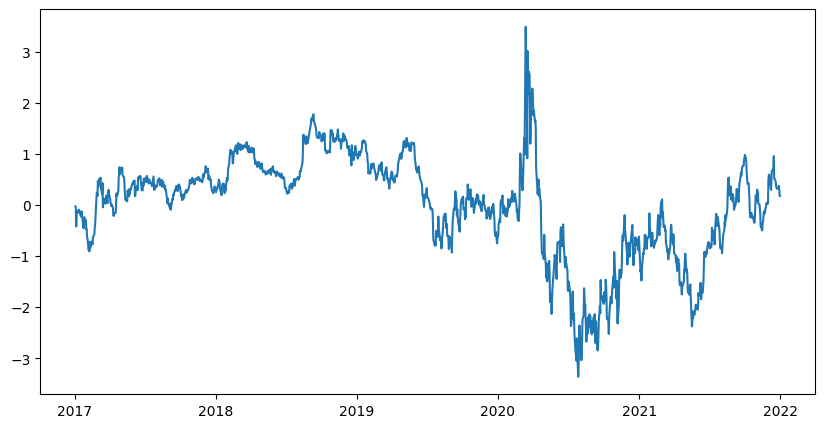



Test Z-Score


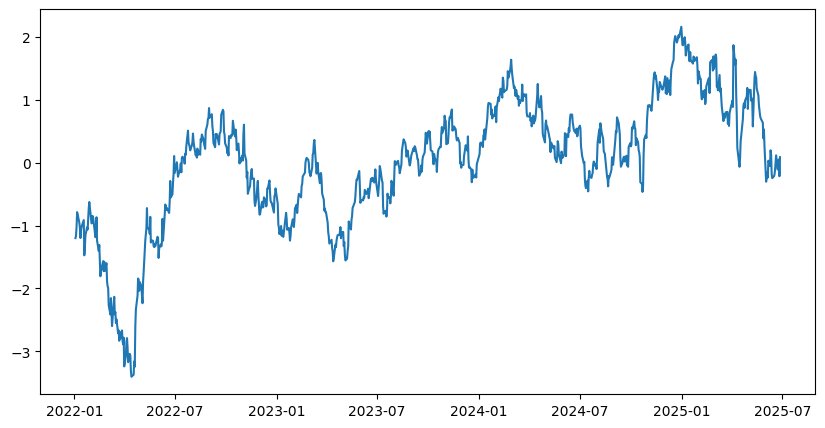

In [9]:
# plot the z-score, to observe
print("\n\nTraining Z-Score")
plt.figure(figsize=(10, 5))
plt.plot(train_data['zscore'])
plt.show()

# plot the z-score, to observe
print("\n\nTest Z-Score")
plt.figure(figsize=(10, 5))
plt.plot(test_data['zscore'])
plt.show()



Training Positions


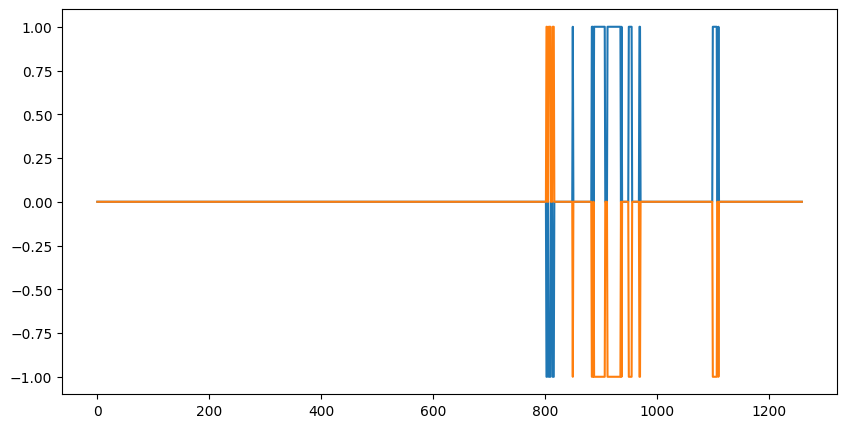



Test Positions


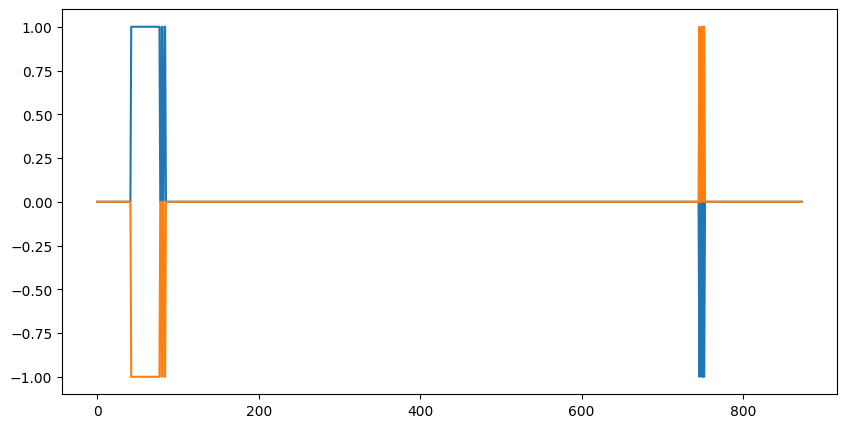

In [10]:
# also plot the positions
print("\n\nTraining Positions")
plt.figure(figsize=(10, 5))
plt.plot(positions_train)
plt.show()

print("\n\nTest Positions")
plt.figure(figsize=(10, 5))
plt.plot(positions)
plt.show()

In [11]:
# seems like at some point the z-score went from >2 to <1 and then back twice

In [12]:
# prepare positions and dailyreturns of each asset for computation of equity curve
positions=pd.DataFrame(positions)
dailyret=test_data.loc[:, ('GLD', 'GDX')].pct_change()

# prepare positions and dailyreturns of each asset for computation of equity curve
positions_train=pd.DataFrame(positions_train)
dailyret_train=train_data.loc[:, ('GLD', 'GDX')].pct_change()

In [13]:
# Compute raw pnl with NumPy
pnl_raw = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1)

# Get mask that filters out NaNs
mask = ~np.isnan(pnl_raw)

# Apply mask to both pnl and index
pnl = pd.Series(pnl_raw[mask], index=dailyret.index[mask])


# do the same with training
pnl_raw_train = (np.array(positions_train.shift()) * np.array(dailyret_train)).sum(axis=1)


mask_train = ~np.isnan(pnl_raw_train)


pnl_train = pd.Series(pnl_raw_train[mask_train], index=dailyret_train.index[mask_train])

In [16]:
# get annualized sharpe ratio, assumption of 5% yield p.a. of riskfree asset, which is a reasonable / conservative assumption in 2025 in my opinion
rf = ((1 + 0.05) ** (1 / 252)) - 1

# HOWEVER: Following the writings + example in his book, I will NOT be subtracting the rf!

print("Training Sharpe:")
#sharpeTrainset = np.sqrt(252)*(np.mean(pnl_train)-rf)/np.std(pnl_train)
sharpeTrainset = np.sqrt(252)*(np.mean(pnl_train))/np.std(pnl_train)
print(sharpeTrainset, end="\n\n")

print("Test Sharpe:")
#sharpeTestset = np.sqrt(252)*(np.mean(pnl)-rf)/np.std(pnl)
sharpeTestset = np.sqrt(252)*(np.mean(pnl))/np.std(pnl)
print(sharpeTestset)



# Ernest P. Chan says in his book "any strategy that has a sharpe ratio of less than 1 is not suitable as a stand-alone strategy", which means that this backtest would've shown evidence of a strategy that is not worth trading
# also "a strategy that achieves profitability almost every month, its (annualized) sharpe ratio is typically greater than 2"

Training Sharpe:
0.7297990424542543

Test Sharpe:
0.4607005232990418




Training PnL


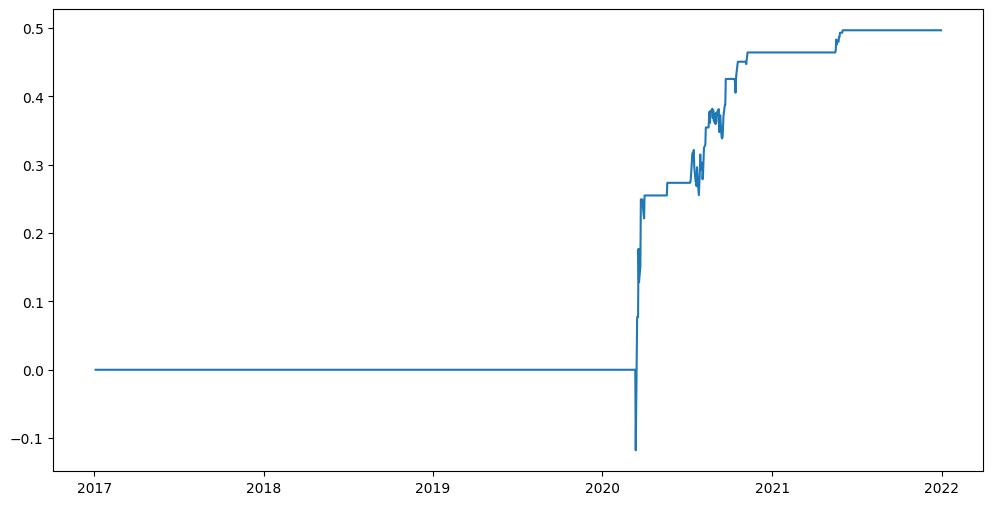



Testing PnL


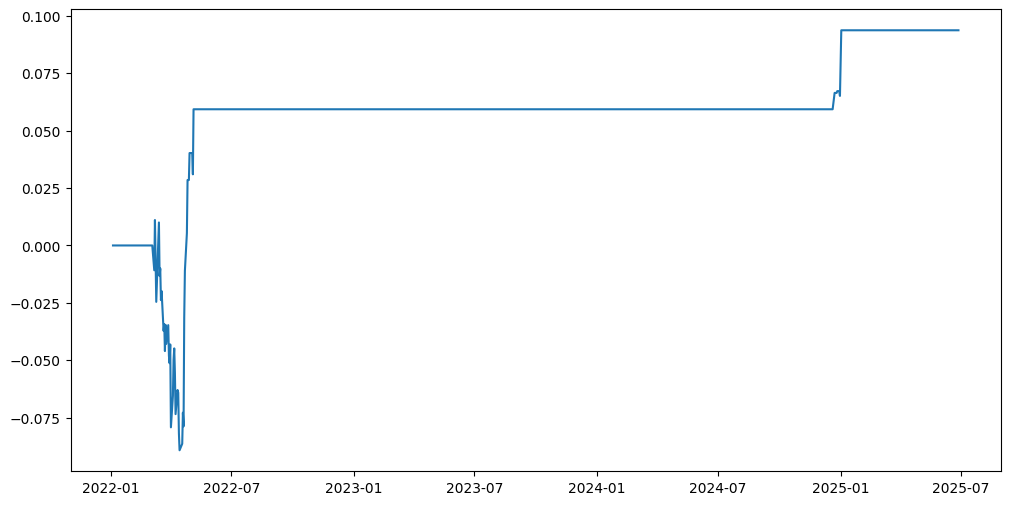

In [17]:
# plot equity curve
print("\n\nTraining PnL")
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pnl_train))
plt.show()

print("\n\nTesting PnL")
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pnl))
plt.show()

In [18]:
print(np.cumsum(pnl)[-1])
#print(np.cumsum(pnl)) # given that this is 2.5 years of testing with a 10% overall return we should annualize that return
annualized_return = ((1+np.cumsum(pnl)[-1])**(1/2.5))-1
print(f"Annualized (out-of-sample) Return of the strategy: {annualized_return} %")

0.09371439139197679
Annualized (out-of-sample) Return of the strategy: 0.03648153781243102 %


/tmp/ipython-input-18-1045269920.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.cumsum(pnl)[-1])
/tmp/ipython-input-18-1045269920.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized_return = ((1+np.cumsum(pnl)[-1])**(1/2.5))-1
